In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Predicting Blitzes Using Pre-Snap Behavior

**By:** Chris Doyle, Hans Elasri, Thomas Garity, Rishi Hazra, and Chris Ruaño (with some debugging assistance from generative AI)

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
4. [Feature Engineering](#Feature-Engineering)
5. [Modeling Approach](#Modeling-Approach)
6. [Model Training and Evaluation](#Model-Training-and-Evaluation)
7. [Results and Insights](#Results-and-Insights)
8. [Next Steps](#Next-Steps)


## Introduction

Blitzing is one of the most aggressive and high-risk strategies in football. It is such an important phenomenon that the term has worked its way into everyday vernacular, in offices and at dinner tables alike. When executed well, it can disrupt an offensive drive by forcing the quarterback into rushed decisions; when misread or mistimed, it can leave the defense vulnerable to big plays. Offensive coaches and quarterbacks spend countless hours studying pre-snap cues to anticipate incoming blitzes, while defenses work just as hard to disguise them through subtle shifts, delayed rushes, and simulated pressures.

Our project aims to bring analytics into this equation by predicting whether a defense will blitz, using only pre-snap player tracking data from the NFL Big Data Bowl 2025 dataset. By extracting features such as player positioning, movement trends, alignment depth, and formation structure, we seek to develop machine learning models that systematically classify plays as blitz or non-blitz scenarios. Of course, our goal is to go beyond what humans have typically been able to detect using long-established heuristics like linebacker positioning to best anticipate the presence of incoming pass rushers (although our EDA has corroborated the importance of linebackers in particular for blitz probability).

A successful model would not only help identify the most telling pre-snap indicators of pressure but also provide a practical tool for offensive strategists to better anticipate and counter defensive blitzes, enhancing both game preparation and real-time decision-making. Using machine learning tools like memory, we also hope to encapsulate the dependencies that exist from play to play, altering how players and coaches alike react to sequential game decisions and outcomes.

## Data Loading and Preprocessing

Our data can be downloaded from the 2025 Big Data Bowl on [Kaggle](https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data) or using the Kaggle API:

```
kaggle competitions download -c nfl-big-data-bowl-2025
```

**Instructions:**
- Download the dataset and unzip the file `nfl-big-data-bowl-2025.zip`.
- The datasets will be saved in a `\nfl-big-data-bowl-2025` directory within the project repo.
- Ensure that this directory is listed in your `.gitignore` file to avoid pushing large data files to GitHub.

Now, let's check that the data has been downloaded correctly:

In [2]:
# ensure all tables downloaded
print("Data Availabe: ")
os.listdir('./nfl-big-data-bowl-2025/')

Data Availabe: 


['plays.csv',
 'tracking_week_5.csv',
 'tracking_week_4.csv',
 'tracking_week_6.csv',
 'tracking_week_7.csv',
 'tracking_week_3.csv',
 'tracking_week_2.csv',
 'tracking_week_1.csv',
 'players.csv',
 'games.csv',
 'tracking_week_9.csv',
 'tracking_week_8.csv',
 'player_play.csv']

In [3]:
# size of the data
!du -sh nfl-big-data-bowl-2025

7.6G	nfl-big-data-bowl-2025


In [4]:
# load datasets
plays_df = pd.read_csv('./nfl-big-data-bowl-2025/plays.csv')
players_df = pd.read_csv('./nfl-big-data-bowl-2025/players.csv')
games_df = pd.read_csv('./nfl-big-data-bowl-2025/games.csv')
player_play_df = pd.read_csv('./nfl-big-data-bowl-2025/player_play.csv')

Since the tracking data is spread across multiple weekly files (`tracking_week_1.csv`, ..., `tracking_week_9.csv`), we load each week separately and then concatenate them into a single DataFrame called `tracking_weeks`. This ensures that all player tracking data is in one place for easier filtering and merging later.

In [5]:
# combine tracking data into one df
tracking_weeks = pd.DataFrame()
for week in range(1, 10):
    current_week = pd.read_csv(f'./nfl-big-data-bowl-2025/tracking_week_{week}.csv')
    tracking_weeks = pd.concat([tracking_weeks, current_week], ignore_index=True)

To reduce dataset size for faster prototyping and exploratory analysis, we randomly sample 30% of games from `games.csv` and then filter:
- `plays.csv`
- `players.csv`
- `games.csv`
- `player_play.csv`
- `tracking_weeks`

to only keep rows corresponding to those sampled games.

This maintains consistency across all datasets while making loading, EDA, and modeling much faster during early stages. Later, once feature engineering and modeling pipelines are finalized, we can re-run everything on the full dataset if needed.

In [6]:
# randomly sample 30% gameId in games_df and filter plays_df, games_df, player_play_df, tracking_weeks
sampled_game_ids = games_df['gameId'].sample(frac=0.3, random_state=42)
plays_df = plays_df[plays_df['gameId'].isin(sampled_game_ids)]
games_df = games_df[games_df['gameId'].isin(sampled_game_ids)]
player_play_df = player_play_df[player_play_df['gameId'].isin(sampled_game_ids)]
tracking_weeks = tracking_weeks[tracking_weeks['gameId'].isin(sampled_game_ids)]

### `plays_df` Summary

The `plays_df` contains play-level metadata for each snap in the dataset, including information about:
- Game context
- Team information
- Pre-snap expected points and win probabilities
- Play outcomes

However, for our project, we are strictly limited to using pre-snap observable information, i.e. what quarterbacks and offensive coordinators could see and react to in real time. Therefore, we drop variables from `plays_df` that:
- Reflect post-snap outcomes
- Depend on events that occur after the play begins
- Are not available to the offense at the time of the snap

However, before dropping the post-snap outcome columns, we first remove Quarterback kneels and spikes, since defenses do not treat these situations competitively.

For context, kneels are used to run out the clock and avoid contact, with no intent to advance the ball or face pressure, and spikes are clock management plays designed to stop the clock, not real passing attempts.

In [7]:
# drop kneels and spikes
plays_df = plays_df[(plays_df['qbKneel'] != 1) & (plays_df['qbSpike'] != 1)]

In [8]:
# drop unnecessary cols
plays_df = plays_df.drop(columns=['playDescription', 'playNullifiedByPenalty', 'playClockAtSnap', 'passResult',
                                    'passLength', 'targetX', 'targetY', 'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
                                    'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
                                    'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
                                    'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
                                    'yardsGained', 'homeTeamWinProbabilityAdded',
                                    'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
                                    'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
                                    'pff_passCoverage', 'pff_manZone'])

In [9]:
# fill missing offensive formations
plays_df['offenseFormation'] = plays_df['offenseFormation'].fillna('EMPTY')

In [10]:
# convert game clock from MM:SS to total min
def convert_game_clock_to_minutes(game_clock):
    if pd.isna(game_clock):
        return np.nan
    minutes, seconds = map(int, game_clock.split(':'))
    return minutes + seconds / 60
plays_df['gameClock'] = plays_df['gameClock'].apply(convert_game_clock_to_minutes)

### `players_df` Summary

The `players_df` contains static information about each player who appears in the tracking data, including:
- Physical attributes
- Player identifiers
- College and birthdate information

For our project, we are only interested in pre-snap attributes that could realistically impact a player's role or likelihood of blitzing. Therefore, we clean `players_df` by:
- Converting player heights from feet-inches format (e.g., 6-4) into total inches to allow numerical modeling
- Dropping non-predictive fields
- Standardizing `nflId` as a string to ensure consistent joins with other datasets

These steps ensure that `players_df` retains only useful, real-time observable features for predicting defender behavior.

In [11]:
# convert player heights from feet-inches to inches
def convert_height_to_inches(height):
    if pd.isna(height):
        return np.nan
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches
players_df['height'] = players_df['height'].apply(convert_height_to_inches)

In [12]:
# drop unecessary cols and set nflId as string
players_df = players_df.drop(columns=['birthDate', 'collegeName', 'displayName'])
players_df['nflId'] = players_df['nflId'].astype(str)

### `games_df` Summary

The `games_df` contains metadata about each NFL game in the dataset, including:
- Game identifiers
- Team matchups (home team vs. visitor team)
- Game outcomes (final scores)
- Date and time information

For our project, we are primarily interested in game identifiers (`gameId`) to join different datasets together.  
Since final scores, game dates, and times are not available pre-snap and would not affect defensive behavior at the individual play level, we:
- Drop outcome variables
- Drop game timing metadata

This leaves a lightweight `games_df` containing only information needed for merging, without leaking any future results into our modeling pipeline.

In [13]:
# drop unecessary cols
games_df = games_df.drop(columns=['season', 'gameDate', 'gameTimeEastern', 'homeFinalScore', 'visitorFinalScore'])

### `player_play_df` Summary

The `player_play_df` contains player-level metadata for each snap in the dataset, including:
- Individual player statistics (e.g., rushing yards, passing yards, sacks)
- Player identifiers
- Defensive actions (e.g., forced fumbles, interceptions, quarterback hits)
- Blocking and matchup information

For our project, we are primarily interested in attributes that could influence a defender's likelihood of blitzing or getting involved in pressure plays.

Therefore, we clean `player_play_df` by:
- Converting `nflId` to a consistent string format to facilitate reliable merging across datasets
- Selecting a subset of columns related to player activity and defensive pressure that could be useful for future modeling
- Dropping unrelated or outcome-based features tied to post-snap play results, since they would not be observable before the snap

These steps prepare `player_play_df` for integration into our wider dataset, while ensuring that only pre-snap or contextually relevant features are retained. Pre-snap data is important because the whole point of our analysis is to provide contextually relevant and actionable advice to coaches and offensive coordinators, none of which is possible using post-snap data. Even if it were relevant, there would be endogeneity concerns with the outcome variables' correlation with post-snap data. A relevant innovation we make, though, has to do with the use of post-snap data from previous plays within the latent state of our model, providing an added and oft-overlooked layer to our analysis. This, however, is an approach saved for our later analyses and final model pipeline.

In [ ]:
# set nflId as string
player_play_df['nflId'] = player_play_df['nflId'].astype(str)

In [15]:
# select relevant play cols
player_play_df = player_play_df[['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt',
                                    'rushingYards', 'hadDropback', 'passingYards',
                                    'hadPassReception', 'receivingYards',
                                    'fumbles', 'forcedFumbleAsDefense',
                                    'quarterbackHit',
                                    'sackYardsAsDefense', 'soloTackle',
                                    'tackleForALoss', 'tackleForALossYardage', 'hadInterception',
                                    'interceptionYards', 'fumbleRecoveries',
                                    'penaltyYards', 'penaltyNames', 'wasInitialPassRusher',
                                    'causedPressure', 'timeToPressureAsPassRusher',
                                    'getOffTimeAsPassRusher', 'shiftSinceLineset',
                                    'motionSinceLineset',
                                    'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
                                    'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker']]

### `tracking_weeks` Summary

The `tracking_weeks` dataset contains frame-by-frame tracking data for every player and the football, including:
- Player location and movement attributes
- Frame metadata
- Player identifiers

For our project, we want to use only player-specific, pre-snap observable motion data to infer defensive behavior. Therefore, we clean `tracking_weeks` by:
- Converting `nflId` to a consistent string format and removing any artifacts (e.g., ".0")
- Selecting only relevant physical and movement features
- Dropping unnecessary columns not related to real-time player tracking
- Separating out and removing frames where the tracked object is the football, so we focus only on players

These steps ensure that `tracking_weeks` retains only the real-time player movement features necessary for pre-snap blitz prediction, with clean identifiers for merging across datasets.

In [16]:
# set nlfID as string after replacing ".0" with ""
tracking_weeks['nflId'] = tracking_weeks['nflId'].astype(str).str.replace('.0', '', regex=False)

In [17]:
# select important tracking features
tracking_weeks = tracking_weeks[['gameId', 'playId', 'nflId', 'frameId', 'frameType',
                                    'playDirection', 'x', 'y', 's', 'a',
                                    'dis', 'o', 'dir', 'displayName']]

These variables may be the most important. Our data tracts the direction, speed, velocity, and location of every player. The hope for the project is that there is information about a defensive team's plans revealed in the subtle movements of players. Thankfully, we have frame by frame (0.1 s) data, so we are able to investigate the smallest of movements from the players.

In [18]:
# replace ".0" in nflid with ""
tracking_weeks['nflId'] = tracking_weeks['nflId'].astype(str).str.replace('.0', '', regex=False)

In [19]:
# separate out tracking data without ball
tracking_weeks_without_ball = tracking_weeks[tracking_weeks['displayName'] != 'football'].copy()
tracking_weeks_without_ball.drop(columns=['displayName'], inplace=True)

### `master_df` Summary

The `master_df` contains the final merged dataset, structured specifically to support modeling defender behavior at the play and frame level.

Each row in `master_df` represents a single play (or a single pre-snap frame, depending on the version), and contains:
- Play-level metadata (down, yards to go, offense formation, etc.)
- Player-level tracking features (speed, acceleration, orientation, movement direction)
- Player assignments flattened into columns by player slot (`p1`, `p2`, ..., `p11`)
- Time-varying tracking data across frames (where applicable)

By converting player data from a row-wise format into a columnar (wide) format, we are able to retain information about all players in a single flat feature vector per play. This structure is critical because it:
- Allows us to efficiently model blitz behavior using tabular machine learning methods
- Creates the flexibility to eventually extend into recurrent models (RNN/LSTM) if we want to model player movement over time

Through careful cleaning, filtering, and flattening, `master_df` provides a complete, pre-snap observable feature set aligned with our objective of predicting defender blitz behavior.

In [20]:
master_df = pd.DataFrame()

In [21]:
# merge player_play_df with players_df to get player names
master_df = player_play_df.merge(players_df[['nflId', 'position']], on='nflId', how='left')
master_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,hadPassReception,receivingYards,...,timeToPressureAsPassRusher,getOffTimeAsPassRusher,shiftSinceLineset,motionSinceLineset,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,position
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN,G
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN,C
2,2022090800,56,42489,BUF,0,0,0,0,1,6,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,WR
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,43335.0,NaN,NaN,0.0,NaN,T
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,WR


In [22]:
# backup master_df for reuse
old_master_df = master_df.copy()
old_master_df['nflId'] = old_master_df['nflId'].astype(object)
old_master_df.to_csv('old_master_df.csv', index=False)
old_master_df = pd.read_csv('old_master_df.csv')
old_master_df['nflId'] = old_master_df['nflId'].astype(object)

In [23]:
# flatten rows with same gameid and playid by creating new columns per attribute per player
attr_cols = (
    player_play_df.columns[2:].tolist()
  + tracking_weeks.columns[3:].tolist()
  + players_df.columns[1:].tolist()
)
attr_cols = [c for c in dict.fromkeys(attr_cols) if c in master_df.columns]

# assign player slots per play
master_df['player_slot'] = (
    master_df
      .sort_values(['gameId','playId','nflId'])
      .groupby(['gameId','playId'])
      .cumcount()
    + 1
)

# pivot player stats into wide format
wide = (
    master_df
      .set_index(['gameId','playId','player_slot'])[attr_cols]
      .unstack('player_slot')
)

wide.columns = [
    f'{attr}_p{slot}'
    for attr, slot in wide.columns
]

wide = wide.reset_index()

expanded_players = wide

This logic is extremely important. Our biggest challenge was determining how to structure our data. We have 3 tiers of data: information about the play, data on every player for every play, and data on every player per every frame per play. Naively combining these datasets into one master dataframe (like we initially attempted) is intractable with nearly 100 million rows, so we went back to the drawing board. Our plan is to convert the player-level data into columns instead of rows. In this cell, we "flatten" each player's data into a set of columns for each player. This does increase the size of our dataset, but keeps one row per play even after adding information about each player in a play.

In [24]:
# merge player_play_df with plays_df on both playId and gameId
expanded_players = expanded_players.merge(plays_df, on=['playId', 'gameId'], how='left')

In [25]:
# merge master_df with games_df on gameId
expanded_players = expanded_players.merge(games_df, on='gameId', how='left')

In [26]:
# save non-time-varying data
nontime_data = expanded_players.copy()
nontime_data.to_csv('nontime_data.csv', index=False)

In [27]:
# merge master_df with tracking_weeks on gameId, playId, and nflId
master_df = old_master_df.merge(tracking_weeks, on=['gameId', 'playId', 'nflId'], how='left')

In [28]:
# filter tracking data to pre-snap frames only
tracking_weeks_without_ball = tracking_weeks_without_ball[tracking_weeks_without_ball['frameType'] == 'BEFORE_SNAP']

We utilize only BEFORE_SNAP data, as it represents the complete set of information accessible when the decision to blitz must be made during actual gameplay; this decision also saves us a lot of compute since we cut the amount of frames saved to memory in half. We may need to add these frames back for a sophisticated RNN, but that seems intractable.

In [29]:
# merge tracking data (x,y,s,a,dir) into wide format
attr_cols = (
       ['x', 'y', 's', 'a', 'dis', 'o', 'dir']
)

attr_cols = [c for c in dict.fromkeys(attr_cols) if c in tracking_weeks_without_ball.columns]
tracking_weeks_without_ball['player_slot'] = (
    tracking_weeks_without_ball
      .sort_values(['gameId','playId','nflId'])
      .groupby(['gameId','playId', 'frameId'])
      .cumcount()
    + 1
)

wide = (
    tracking_weeks_without_ball
      .set_index(['gameId','playId', 'frameId', 'player_slot'])[attr_cols]
      .unstack('player_slot')
)

wide.columns = [
    f'{attr}_p{slot}'
    for attr, slot in wide.columns
]

wide = wide.reset_index()

tracking_weeks_without_ball = wide

This logic is also very important. It continues the data structure construction mentioned before. What this cell does is flatten the player data into columns as before, but we still have multiple rows per play. Each row represents a different frame (0.1 seconds) during the play, and the player data is "flattened" into columns. With this dataset, we can directly merge it with the previous dataset to get the desired data structure.

In [30]:
# merge tracking_weeks_without_ball with master_df on gameId, playId
master_df = nontime_data.merge(tracking_weeks_without_ball, on=['gameId', 'playId'], how='outer')
master_df.to_csv('master_df.csv', index=False)

In [31]:
# inspect final dataset
master_df.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,dir_p13,dir_p14,dir_p15,dir_p16,dir_p17,dir_p18,dir_p19,dir_p20,dir_p21,dir_p22
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,200.63,169.95,320.02,306.81,242.41,280.71,168.74,328.45,293.55,317.86
1,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,198.46,171.35,319.98,306.45,244.46,281.67,170.11,328.51,293.95,312.00
2,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,195.91,173.34,318.91,310.47,245.36,282.33,171.82,328.92,294.58,304.65
3,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,194.20,173.88,318.35,321.06,245.46,282.62,173.48,330.85,295.03,297.01
4,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,192.81,175.64,317.23,337.88,244.06,282.70,176.03,333.96,295.55,291.28


Now we have exactly what we desire: a dataset that contains every player's information in columns rather than rows, and rows that update the information per 0.1 second so that we have time series data. Now we can see how a play progresses by moving down the rows for a specific game ID and play ID; this structure is perfect for an RNN.

### Blitz Labeling Methodology

To label whether a play is a blitz, we adopt a method inspired by Dominic Borsani’s approach in the 2023 NFL Big Data Bowl. Rather than relying directly on provided scouting labels, we infer blitz likelihood based on **pre-snap defender behavior** observable in the tracking data.

Specifically, we use the following steps:

- Merge tracking data (`tracking_week_*`) with play metadata from `plays.csv` to access line of scrimmage (`LOS`) information.
- Identify **frames where `frameType == 'SNAP'`**, which correspond to the official ball snap moment.
- For each defender at ball snap:
  - **Distance from LOS**: Compute the absolute difference between the player’s `x` coordinate and the line of scrimmage (`LOS_x`), adjusted for play direction.
  - **Motion Toward LOS**: Estimate whether a player is moving toward the ball using the `dir` (direction) and `playDirection`.
  - **Velocity Toward LOS**: Calculate as `speed × motion_toward_ball`.
- A defender is flagged as a **likely blitzer** if:
  - They are **within 5 yards** of the line of scrimmage at the snap, **and**
  - They are **moving toward the LOS at greater than 1.5 yards per second**.
- At the play level, we sum the number of players flagged as likely blitzers.

We define a **blitz play** as one where **more than 1 defender** meets the blitz criteria at the snap. This threshold aligns with the intuition that sending multiple extra rushers constitutes a true blitz rather than just a normal pass rush.

---

### Reference

Borsani, D. (2023). *Beat the Offensive Line: Using Data to Determine Blitz Strategy.* NFL Big Data Bowl, Finalist Project.


In [32]:
# count unique plays
unique_plays = tracking_weeks[['gameId', 'playId']].drop_duplicates()
print(f"Number of unique plays: {len(unique_plays)}")

Number of unique plays: 4886


In [33]:
# merge LOS info into tracking
plays_subset = plays_df[['gameId', 'playId', 'yardlineNumber', 'yardlineSide', 'absoluteYardlineNumber']]
tracking = tracking_weeks.merge(plays_subset, on=['gameId', 'playId'], how='left')

# keep only frames at ball snap
snap_tracking = tracking[tracking['frameType'] == 'SNAP'].copy()

# calculate LOS x-coordinate
def calculate_los_x(playDirection, absoluteYardlineNumber):
    if playDirection == 'left':
        return 100 - absoluteYardlineNumber
    else:
        return absoluteYardlineNumber

snap_tracking['LOS_x'] = snap_tracking.apply(
    lambda row: calculate_los_x(row['playDirection'], row['absoluteYardlineNumber']), axis=1
)

# distance from LOS
snap_tracking['dist_from_LOS'] = np.abs(snap_tracking['x'] - snap_tracking['LOS_x'])

# motion toward LOS
def motion_toward_ball(row):
    if row['playDirection'] == 'left':
        return np.cos(np.deg2rad(row['dir']))
    else:
        return np.cos(np.deg2rad(row['dir'] - 180))

snap_tracking['motion_toward_ball'] = snap_tracking.apply(motion_toward_ball, axis=1)

# velocity toward LOS
snap_tracking['velocity_toward_LOS'] = snap_tracking['s'] * snap_tracking['motion_toward_ball']

# label likely blitzers
snap_tracking['isLikelyBlitzer'] = (
    (snap_tracking['dist_from_LOS'] <= 5) &
    (snap_tracking['velocity_toward_LOS'] > 1.5)
).astype(int)

In [34]:
# count likely blitzers
num_likely_blitzers = snap_tracking['isLikelyBlitzer'].sum()
print(f"Total number of players flagged as likely blitzers: {num_likely_blitzers}")

Total number of players flagged as likely blitzers: 543


In [35]:
# count blitzers per play
blitzer_counts_by_play = snap_tracking.groupby(['gameId', 'playId'])['isLikelyBlitzer'].sum().reset_index()
print(blitzer_counts_by_play.head())

       gameId  playId  isLikelyBlitzer
0  2022090800      56                0
1  2022090800      80                0
2  2022090800     101                0
3  2022090800     122                0
4  2022090800     167                0


In [36]:
# count plays with 1+ blitzer
plays_with_blitzers = blitzer_counts_by_play[blitzer_counts_by_play['isLikelyBlitzer'] > 0]
num_plays_with_blitzers = len(plays_with_blitzers)

# count total unique plays
total_plays = len(blitzer_counts_by_play)

# calculate percentage
blitz_percentage = (num_plays_with_blitzers / total_plays) * 100 if total_plays > 0 else 0

print(f"Total plays: {total_plays}")
print(f"Plays with at least one blitzer: {num_plays_with_blitzers}")
print(f"Percentage of plays with blitzers: {blitz_percentage:.2f}%")

Total plays: 4886
Plays with at least one blitzer: 350
Percentage of plays with blitzers: 7.16%


In [37]:
# count pass plays
pass_plays = plays_df[plays_df['isDropback'] == 1]
print(f"Number of pass plays: {len(pass_plays)}")

# calculate percentage of pass plays with blitzers
pass_plays_with_blitzers = pass_plays[pass_plays['playId'].isin(plays_with_blitzers['playId'])]
num_pass_plays_with_blitzers = len(pass_plays_with_blitzers)
pass_plays_total = len(pass_plays)
pass_blitz_percentage = (num_pass_plays_with_blitzers / pass_plays_total) * 100 if pass_plays_total > 0 else 0
print(f"Total pass plays: {pass_plays_total}")
print(f"Pass plays with at least one blitzer: {num_pass_plays_with_blitzers}")
print(f"Percentage of pass plays with blitzers: {pass_blitz_percentage:.2f}%")

Number of pass plays: 3039
Total pass plays: 3039
Pass plays with at least one blitzer: 425
Percentage of pass plays with blitzers: 13.98%


In [38]:
# breakdown of plays by number of blitzers
blitzer_distribution = blitzer_counts_by_play['isLikelyBlitzer'].value_counts().sort_index()
print("\nDistribution of blitzers per play:")
print(blitzer_distribution)


Distribution of blitzers per play:
isLikelyBlitzer
0    4536
1     204
2     112
3      25
4       6
5       2
6       1
Name: count, dtype: int64


In [39]:
# classify plays as blitzes if the number of likely blitzers exceeds threshold_for_blitz_play
threshold_for_blitz_play = 1
plays_with_significant_blitz = blitzer_counts_by_play[blitzer_counts_by_play['isLikelyBlitzer'] > threshold_for_blitz_play]
print(f"\nPlays with more than {threshold_for_blitz_play} blitzer(s): {len(plays_with_significant_blitz)}")
print(f"Percentage: {(len(plays_with_significant_blitz) / total_plays) * 100:.2f}%")


Plays with more than 1 blitzer(s): 146
Percentage: 2.99%


In [40]:
# set output to 1 if isLikelyBlitzer > threshold_for_blitz_play else 0
blitz_outcome = blitzer_counts_by_play.copy()
blitz_outcome['blitzOutcome'] = blitz_outcome['isLikelyBlitzer'].apply(lambda x: 1 if x >= threshold_for_blitz_play else 0)
blitz_outcome = blitz_outcome[['gameId', 'playId', 'blitzOutcome']]
blitz_outcome = blitz_outcome.drop_duplicates()
blitz_outcome = blitz_outcome.dropna()
blitz_outcome.head()

,gameId,playId,blitzOutcome
0,2022090800,56,0
1,2022090800,80,0
2,2022090800,101,0
3,2022090800,122,0
4,2022090800,167,0


## Exploratory Data Analysis (EDA)

In this section, we examine patterns in key pre-snap features that are likely to correlate with defender blitz behavior.

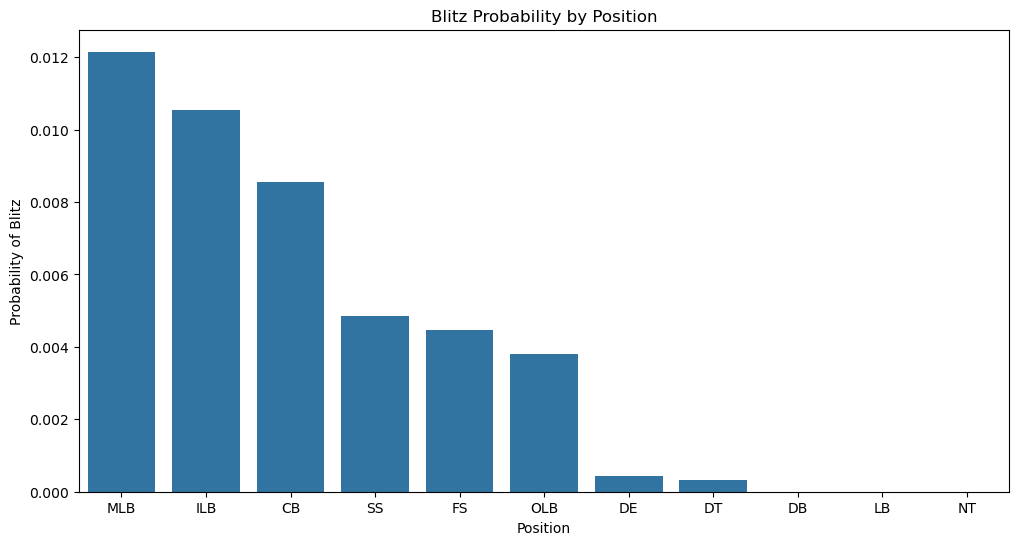

In [48]:
# define defensive positions
defensive_positions = ['CB', 'S', 'FS', 'SS', 'NB', 'ILB', 'LB', 'OLB', 'DE', 'DT', 'NT', 'DB', 'MLB']

# merge player positions
snap_with_position = snap_tracking.merge(players_df[['nflId', 'position']], on='nflId', how='left')

# filter to defenders only
snap_with_position = snap_with_position[snap_with_position['position'].isin(defensive_positions)]

# group and calculate blitz probability per position
position_blitz_probs = (
    snap_with_position.groupby('position')['isLikelyBlitzer']
    .mean()
    .sort_values(ascending=False)
)

# reset index to plot cleanly
position_blitz_probs = position_blitz_probs.reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    data=position_blitz_probs,
    x='position',
    y='isLikelyBlitzer',
)

plt.title('Blitz Probability by Position')
plt.ylabel('Probability of Blitz')
plt.xlabel('Position')
plt.show()

Middle linebackers (MLB) and inside linebackers (ILB) show the highest likelihood of blitzing, followed closely by cornerbacks (CB). Defensive linemen (DE, DT) and nose tackles (NT) rarely appear as likely blitzers, consistent with their typical roles as primary pass rushers rather than surprise blitzers.

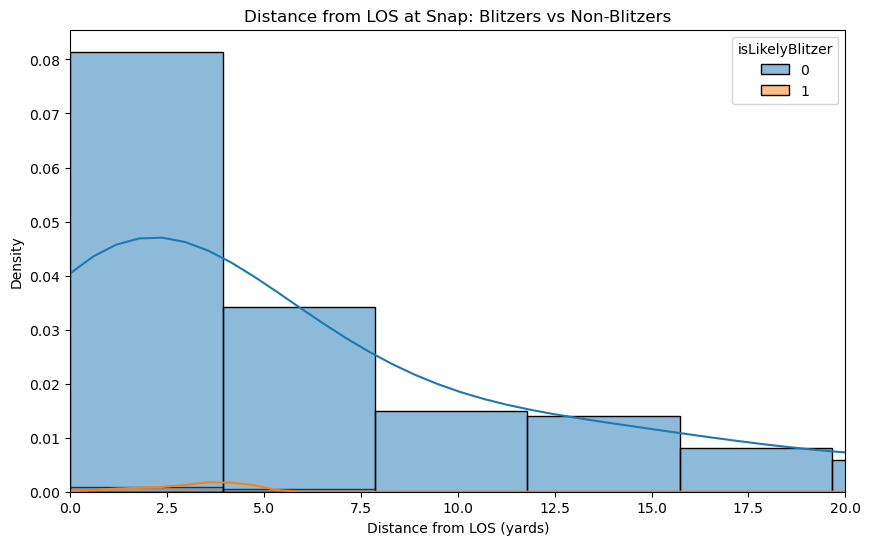

In [42]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=snap_with_position,
    x='dist_from_LOS',
    hue='isLikelyBlitzer',
    bins=30,
    kde=True,
    stat='density'
)

plt.title('Distance from LOS at Snap: Blitzers vs Non-Blitzers')
plt.xlabel('Distance from LOS (yards)')
plt.ylabel('Density')
plt.xlim(0, 20)
plt.show()

Defenders who blitz are overwhelmingly positioned within 5 yards of the line of scrimmage at the snap, while non-blitzers show a broader spread of distances. However, not all defenders lined up close to the LOS blitz, indicating that while proximity is a strong indicator, it alone is not sufficient for predicting blitz behavior.

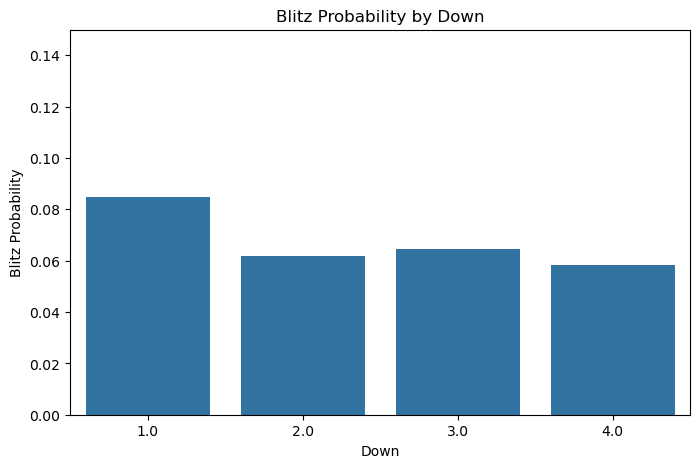

In [43]:
#mMerge down info and blitz outcome
down_blitz_df = blitzer_counts_by_play.merge(
    plays_df[['gameId', 'playId', 'down']],
    on=['gameId', 'playId'],
    how='left'
).merge(
    blitz_outcome,
    on=['gameId', 'playId'],
    how='left'
)

# calculate blitz probability by down
blitz_prob_by_down = down_blitz_df.groupby('down', observed=True)['blitzOutcome'].mean()

plt.figure(figsize=(8,5))
sns.barplot(
    x=blitz_prob_by_down.index,
    y=blitz_prob_by_down.values,
)

plt.title('Blitz Probability by Down')
plt.xlabel('Down')
plt.ylabel('Blitz Probability')
plt.ylim(0, 0.15)
plt.show()

Blitz probability is highest on first down, suggesting that defenses in this sample may attempt to create early disruption before offenses can get into rhythm. Blitzing rates are slightly lower but relatively stable across second, third, and fourth downs, contrasting with the common expectation of increased pressure on obvious passing downs.

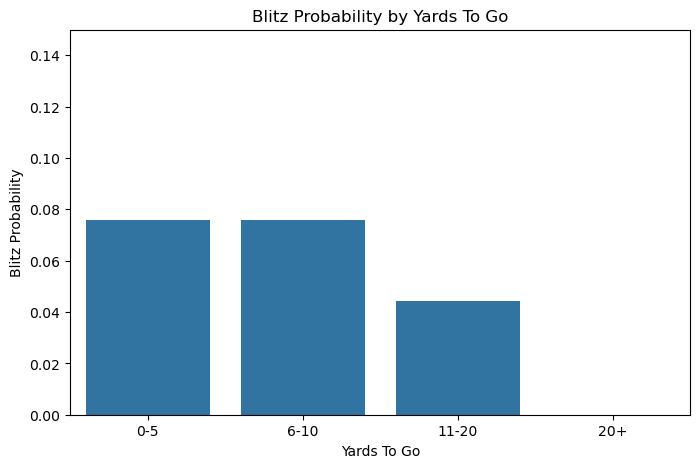

In [44]:
# merge yardsToGo and blitzOutcome into blitzer_counts_by_play
blitz_with_yards = blitzer_counts_by_play.merge(
    plays_df[['gameId', 'playId', 'yardsToGo']],
    on=['gameId', 'playId'],
    how='left'
).merge(
    blitz_outcome,
    on=['gameId', 'playId'],
    how='left'
)

# create yards_to_go buckets
blitz_with_yards['yards_bucket'] = pd.cut(
    blitz_with_yards['yardsToGo'],
    bins=[0,5,10,20,50],
    labels=['0-5','6-10','11-20','20+']
)

# calculate blitz probability per bucket
bucket_blitz_probs = blitz_with_yards.groupby('yards_bucket', observed=True)['blitzOutcome'].mean()

plt.figure(figsize=(8,5))
sns.barplot(
    x=bucket_blitz_probs.index,
    y=bucket_blitz_probs.values,
)

plt.title('Blitz Probability by Yards To Go')
plt.xlabel('Yards To Go')
plt.ylabel('Blitz Probability')
plt.ylim(0, 0.15)
plt.show()

Blitz probability is highest when the offense faces short-yardage situations (0–5 yards and 6–10 yards), suggesting that defenses are more aggressive when offenses are likely to run quick plays. Blitzing becomes noticeably less common as the distance to gain increases, with very few blitzes on plays requiring 11+ yards for a first down.

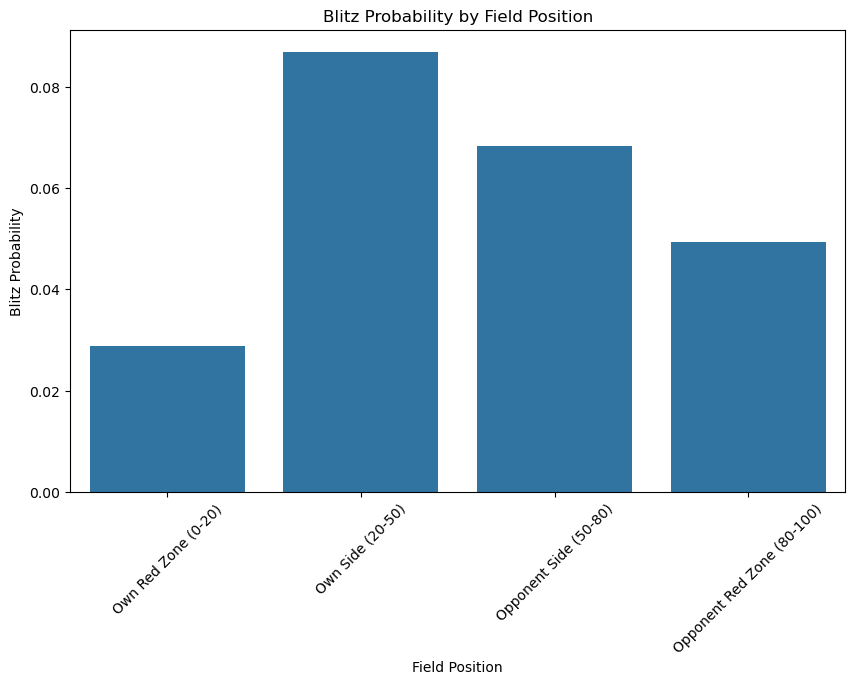

In [45]:
# merge field position info and blitz outcome
blitz_with_fieldpos = blitzer_counts_by_play.merge(
    plays_df[['gameId', 'playId', 'absoluteYardlineNumber']],
    on=['gameId', 'playId'],
    how='left'
).merge(
    blitz_outcome,
    on=['gameId', 'playId'],
    how='left'
)

# create field buckets
blitz_with_fieldpos['field_bucket'] = pd.cut(
    blitz_with_fieldpos['absoluteYardlineNumber'],
    bins=[0,20,50,80,100],
    labels=['Own Red Zone (0-20)','Own Side (20-50)','Opponent Side (50-80)','Opponent Red Zone (80-100)']
)

# calculate blitz probability by field position
fieldpos_blitz_probs = blitz_with_fieldpos.groupby('field_bucket', observed=True)['blitzOutcome'].mean()

plt.figure(figsize=(10,6))
sns.barplot(
    x=fieldpos_blitz_probs.index,
    y=fieldpos_blitz_probs.values,
)

plt.title('Blitz Probability by Field Position')
plt.xlabel('Field Position')
plt.ylabel('Blitz Probability')
plt.xticks(rotation=45)
plt.show()


Blitz probability is highest when the opposing offense is backed up on its own side of the field (20–50 yard line), suggesting that defenses may become more aggressive when they have more field to defend behind them. Blitzing becomes less common as the offense approaches the red zone, likely reflecting more conservative strategies to avoid giving up big plays in critical scoring territory.

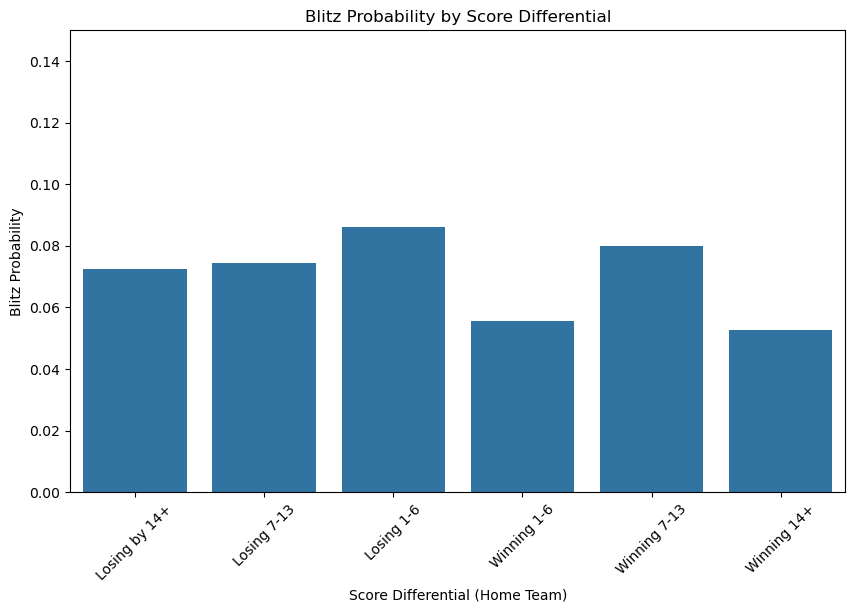

In [46]:
# create score differential
plays_df['scoreDifferential'] = plays_df['preSnapHomeScore'] - plays_df['preSnapVisitorScore']

# merge blitzOutcome into plays_df
plays_with_blitz = plays_df.merge(
    blitz_outcome,
    on=['gameId', 'playId'],
    how='left'
)

# bucket score differential
plays_with_blitz['score_bucket'] = pd.cut(
    plays_with_blitz['scoreDifferential'],
    bins=[-50, -14, -7, 0, 7, 14, 50],
    labels=['Losing by 14+', 'Losing 7-13', 'Losing 1-6', 'Winning 1-6', 'Winning 7-13', 'Winning 14+']
)

# calculate blitz probability by score bucket
blitz_prob_by_score = plays_with_blitz.groupby('score_bucket', observed=True)['blitzOutcome'].mean()

plt.figure(figsize=(10,6))
sns.barplot(
    x=blitz_prob_by_score.index,
    y=blitz_prob_by_score.values,
)

plt.title('Blitz Probability by Score Differential')
plt.xlabel('Score Differential (Home Team)')
plt.ylabel('Blitz Probability')
plt.xticks(rotation=45)
plt.ylim(0, 0.15)
plt.show()

Blitz probability appears relatively stable across different score differentials, suggesting that teams are not dramatically changing blitz aggressiveness based on whether they are winning or losing. However, there is some slight increase in blitzing when teams are trailing by large margins, possibly reflecting more desperate defensive strategies.

## Feature Engineering

All of the features that we've explored in our EDA can be seen to be important as we approach our final model. Notably, since we're on the hunt for tells that are beyond human intuition or attention, even slight phenomena could give us the extra edge that helps to determine the difference between a win or a loss. To get everything into appropriate formats for our baseline model, logistic regression, we do the feature engineering below.

In [ ]:
master_df = pd.read_csv('master_df.csv')
nontime_data = pd.read_csv('nontime_data.csv')

Here, we notably just fill in the missing fields to have a valid regression. In our data, all missing data is encoded as "Unknown", which we just fill as NA for the purposes of letting the rest of our regression work as intended. We don't discard these rows for several reasons. First, many of our features include missing observations because the events they track haven't occurred. In the case of rare events like fumbles, this is especially relevant. While fumbles have a large impact on gameplay and morale, they don't happen often. It would be a pity to lose that context, but we need a workable way to deal with missingness, which is NA.

In [ ]:
# fill all missing categorical fields
categorical_cols = []
for col in nontime_data.select_dtypes(include=['object']).columns:
    if col not in ['gameId', 'playId', 'nflId']:
        categorical_cols.append(col)
for col in categorical_cols:
    nontime_data[col] = nontime_data[col].fillna('Unknown')

# one-hot encode categorical cols
snap_tracking_encoded = pd.get_dummies(
    nontime_data,
    columns=categorical_cols,
    drop_first=True
)

# sort data by gameId and playId 
snap_tracking_encoded.sort_values(['gameId', 'playId'])

Now we just have to prepare our data properly so that we can make it work for our logistic regression. Here, we drop our IDs, which aren't relevant for analysis now that everything is organized, and get ready to run the logistic regression.

In [ ]:
# prepare feature matrix X by dropping ID cols
X = snap_tracking_encoded.drop(columns=['gameId', 'playId'])

# drop any remaining object-type columns from X
for col in X.select_dtypes(include=['object']).columns:
    X = X.drop(columns=[col])

# Sort target variable by gameId and playId to match X
blitz_outcome = blitz_outcome.sort_values(['gameId', 'playId'])
y = blitz_outcome['blitzOutcome']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=109)

## Modeling Approach

In [ ]:
# impute missing values annd adjust for class imbalance
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),           
    LogisticRegression(max_iter=1000,
                       class_weight='balanced')
)

## Model Training and Evaluation

In [ ]:
# logistic regression
logreg = pipeline.fit(X_train, y_train)

In [ ]:
# evaluate results
y_pred = logreg.predict(X_test)
print("Classification Report (Logistic Regression Baseline):")
print(classification_report(y_test, y_pred))

## Final Model Pipeline

**Here is a high-level overview of the pipeline. Continue scrolling to see a basic implementation with more detail on assumptions and design choices.**

--

For our final model, we will adopt an RNN architecture. While some elements (like the hyperparameters, specific architecture, and feature selection) will be determined as we iterate, we will begin with a baseline model and then iteratively improve it.

We will iterate through the following approaches:
1. **Baseline RNN**: Feed through sequences of N rows of data. Each row corresponds to one play, and sequence is made up of N consecutive plays. The final play is the target -- the model must predict whether or not a blitz occurred in the final play.
2. **Frame-by-Frame RNN:** Feed through sequences of N rows of data. Each row corresponds to one frame of a single play. The final frame is the target -- the model must predict whether or not a blitz occurred within this play. 
3. **Mixture of Both:** Run both types of RNN. Combine the hidden states before a MLP head predicts the final blitz / no blitz output.

Our Pipeline will be as follows:

1. **PREPROCESSING**
   1. One hot encode categorical variables (teams, positions, formations)
   2. Drop columns that are un-usable.
   3. Create sequences, using a sliding window. Write a function for creating sequences -- we want the sliding window size to be flexible (we may want to change this later)
2. **MODELING**
   1. Define the architecture; the input should be N * (sequence length) * (number of features)
   2. Work with some sort of RNN units -- either RNN, GRU, or LSTM
   3. Output of final dense layer should be one logits with sigmoid activation for binary classification.
   4. We will minimize the binary cross-entropy loss -- this is the most logical approach, as we have chosen to have 1 logit.
3. **TRAINING**
   1. Train the model on the training data. Log loss, accuracy, and validation accuracy
   2. Plot training results over each epoch

### Preprocessing 
Using similar logic to the logistic regression, we:
- one-hot encode categorical variables (teams, positions, formations)
- cast boolean variables to integers
- drop columns that are un-usable
- fill Nans with 0 -- these mainly correspond to boolean variables for players whose positions do not apply (i.e. defensive stats for an offensive player), so zeroes are appropriate

To obtain our target label, we merge in from the `blitz_outcome` df. In our next imeplementation, we would save those blitz labels to the .csv file itself.

The next step is creating sequences. This is the format ready for the model. We have begun with a sequence length of 5, as this allows us to summarize any trends in the current drive, while also peeking at the previous drive as well. In the future we might experiment with:
- very large (30+) sequence lengths to capture multiple possessions from both teams
- recreate this logic at the frame-level; so we are looking more at real-time decisions (this is closer to our problem statement)


NOTE: We have cut off our dataset at only 2 games here. Change the `cutoff` argument to `None` to use the full dataset.

 

In [ ]:
# Import dataframe
df = pd.read_csv('nontime_data.csv')

In [ ]:
# Use the existing mapping of plays --> blitzes to add the target column
df = df.merge(blitz_outcome[['gameId', 'playId', 'blitzOutcome']], 
              on=['gameId', 'playId'], 
              how='left'
          )

In [ ]:
# fill all missing categorical fields
categorical_cols = []
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['gameId', 'playId', 'nflId']:
        categorical_cols.append(col)
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# one-hot encode categorical cols
df = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)

# drop any remaining object-type columns from X
for col in df.select_dtypes(include=['object']).columns:
    df = df.drop(columns=[col])

# Convert boolean columns to integers (0/1) first
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Drop remaining rows with any NaN
df = df.dropna(subset=['blitzOutcome', 'quarter', 'down', 'yardsToGo', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints'])

# Fill remaining NaNs with 0
df = df.fillna(0)


In [ ]:
def create_sequences(df, n=5, target_col='blitzOutcome', step=1, cutoff=2):
    """
    Create sequences of n consecutive plays for RNN input with overlapping windows.
    
    Parameters:
    -----------
    df : DataFrame with last frame of each play
    n : Sequence length (number of plays to include in each sequence)
    target_col : Column name for the target variable (blitz indicator)
    step : Step size for sliding window (1 = maximum overlap, n = no overlap)
    cutoff : how many games to repeat this process for (for prototyping)

    Returns:
    --------
    X : numpy array of shape (num_sequences, n, num_features)
        Sequences of n plays with features
    y : numpy array of shape (num_sequences,)
        Target values indicating whether the n+1th play was a blitz
    play_ids : list of tuples
        Identifiers for the play following each sequence (for reference)
    """
    X = []
    y = []
    play_ids = []
    
    # list of unique games
    games = df['gameId'].unique()
    
    # Handle cutoff=None
    if cutoff is None:
        cutoff = len(games)

    for game_id in games[:cutoff]:
        # Get plays for this game and sort chronologically
        game_plays = df[df['gameId'] == game_id].sort_values(['quarter', 'gameClock'], ascending=[True, False])
        
        # Get the length of this game in plays
        game_length = len(game_plays)
        
        # Skip games that are too short for our sequence length
        if game_length <= n:
            continue
            
        # Specify which features to use
        feature_cols = [col for col in df.columns if col not in ['gameId', 'playId', 'blitzOutcome']]
        
        # Convert to numpy for faster operations
        plays_array = game_plays[feature_cols].values
        targets_array = game_plays[target_col].values if target_col in game_plays.columns else None
        play_ids_array = game_plays['playId'].values

        # Create overlapping windows
        for i in range(0, game_length - n, step):
            # Get n consecutive plays for X
            sequence = plays_array[i:i+n]
            
            # Skip sequences with NaN values if needed
            # Although we should not have any at this point
            if np.isnan(sequence).any():
                # Flag it so we can debug
                print('skipping')
                continue
                
            # Add the sequence to our dataset
            X.append(sequence)
            
            # Get target from the n+1th play (if target column exists)
            if targets_array is not None:
                y.append(targets_array[i+n])
                
            # Keep track of which play this prediction is for
            # This is mainly for interpretability
            play_ids.append((game_id,play_ids_array[i+n]))
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y) if targets_array is not None else None
    
    print(f"Created {len(X)} sequences of length {n}")
    print(f"X shape: {X.shape}")
    if y is not None:
        print(f"y shape: {y.shape}")
    
    return X, y, play_ids

In [ ]:
# Prepare sequences
X, y, play_ids = create_sequences(df, n=5, target_col='blitzOutcome', step=3, cutoff=2)
# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define RNN Model

We have not put extreme thought into this model yet -- that will be work for Milestone 5. However, with this working scaffolding, we can begin to iterate. Some design decisions we have made already are:
- **Tracking precision / recall** -- we know that blitzes are rare, so it is important that we know whether we are correctly identifying them (not just predicting the majority class)
- **Bidirectional LSTM layers** -- we were impressed by LSTMs in psets so have chosen them as the starting point. We have chosen bidirectional thinking that football strategies are somewhat bidirectional as well ; a defensive coordinator both looks back and previous plays and plans for potential future plays to lead their decisions. We need to test this logic further through experiments with regular and bidirectional plays.
- **Dropout** -- there is a risk of overfitting with this type of task (very noisy, small dataset), so we have added dropout to prevent overfitting.
- **Early Stopping** -- we have added early stopping to prevent overfitting.
- **Batch Normalization** -- same as above ; one more measure to prevent overfitting.

In [ ]:
def create_blitz_rnn_model(n_timesteps, n_features, dropout_rate=0.3):
    model = Sequential([
        # Input layer
        Input(shape=(n_timesteps, n_features)),
        
        # Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Second bidirectional LSTM layer
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Dense hidden layer
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate/2),
        
        # Output layer with 2 neurons (probability of blitz and no blitz)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model with binary cross-entropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

In [ ]:
RNN_model = create_blitz_rnn_model(n_timesteps=X.shape[1], n_features=X.shape[2])

### Training Run

Keep in mind, this is a demo -- we would run this for more epochs and tune our hyperparameters for our final model.

Be sure to update the # of epochs to be greater than 1.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    ModelCheckpoint('best_blitz_model.h5', save_best_only=True)
]

history = RNN_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=32,
    callbacks=callbacks
)

### Evaluate Model

In [ ]:
# Inspect Logs
loss, accuracy, auc, precision, recall = RNN_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

## Results and Insights

## Next Steps